# Feature selection
In this notebook, we cover the process that led to the selection of useful features in the dataset, including statistical tests

In [1]:
# Import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import statUtils as su

In [2]:
CLEAN_PATH = "../../assets/clean/"
account_data = pd.read_csv("../../assets/clean/account.csv")
card_data = pd.read_csv("../../assets/clean/card_dev.csv")
client_data = pd.read_csv("../../assets/clean/client.csv")
disp_data = pd.read_csv("../../assets/clean/disp.csv", dtype={"disp_id": int, "client_id": int, "account_id": int, "type": str})
district_data = pd.read_csv("../../assets/clean/district.csv")
loan_data = pd.read_csv("../../assets/clean/loan_dev.csv")
transaction_data = pd.read_csv("../../assets/clean/trans_dev.csv", dtype=
    {"trans_id": int, "account_id": int, "date": str, "type": str, "operation": str, "amount": float, "balance": float, "k_symbol": str, "bank": str, "account": str}
)

joined_data = pd.read_csv("../../assets/joined/data.csv")

IS_LOADED = False

In [3]:
# Change pandas display options
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

### Transactions analysis

Verify the correlation between the *type* and *operation* columns of Transactions

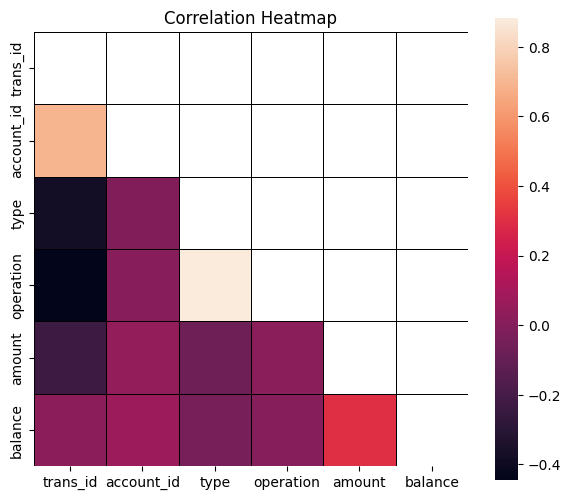

In [4]:
if not IS_LOADED:
    # convert 'type' and 'operation' columns to numeric catorical values
    transaction_data['type'] = transaction_data['type'].astype('category').cat.codes
    transaction_data['operation'] = transaction_data['operation'].astype('category').cat.codes

su.plot_corr(transaction_data, transaction_data.columns, methodName="spearman", annot=False, figSize=(7, 6))

As we can see, the 'type' and 'operation' columns have a very high correlation. This proves what we mentioned in [Data Analysis](./dataAnalysis.ipynb) and for that reason we can ignore one of them. The preferred attribute to mantain is the *type*, since it does not suffer from consistency issues

--------------

## Feature Engineering

Most models and correlation algorithms handle numerical data better. For this reason, we will try to convert the possible fields to this type

### Dates -> Numerical
Currently, dates are in the format "YYYY-MM-DD", we will convert them to "YYMMDD". 
But first, we will add a new column for the client's age at the time of the loan:

In [5]:
def find_year(df):
    # Create a new age column with the client's age
    loan_dates = pd.to_datetime(df["loan_date"], format="%Y-%m-%d")
    birth_dates = pd.to_datetime(df["birth_number"], format="%Y-%m-%d")
    
    client_ages = []
    for i in range(len(loan_dates)):
        # A bool that represents if the loan's day/month precedes the birth date's day/month
        year_offset = (loan_dates[i].month, loan_dates[i].day) < (birth_dates[i].month, birth_dates[i].day)

        year_diff = loan_dates[i].year - birth_dates[i].year

        # Subtract the offset from the year difference to take into account the month and day in the age calculation
        client_ages.append(year_diff - year_offset)
    df["age"] = client_ages
    

if not IS_LOADED:
    find_year(joined_data)

Now analyzing the distribution of age and its relation with other variables:

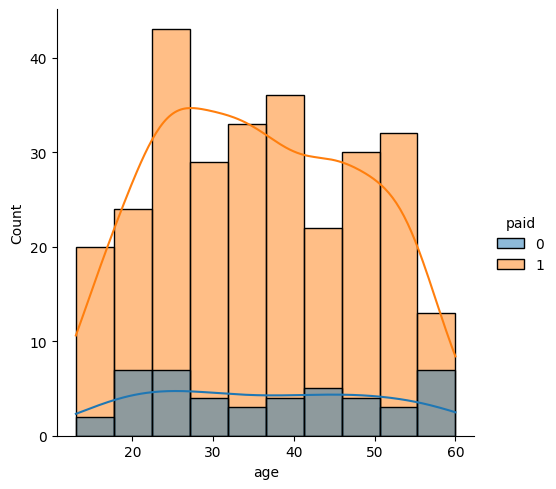

In [6]:
sb.displot(x="age", data=joined_data, kde=True, hue="paid")

As we can see, some age groups have a lower ratio of paid_loans, especially the 55-60 group

<AxesSubplot: xlabel='age', ylabel='balance_mean'>

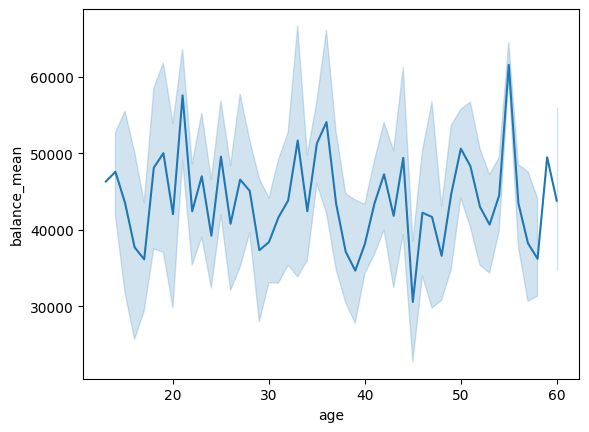

In [7]:
sb.lineplot(x="age", y="balance_mean", data=joined_data)

Surprisingly, the balance mean does not seem to change significantly with the age

### Client's age discretization
By observing the graph above, we can detect age groups where the ratio of paid loans is different

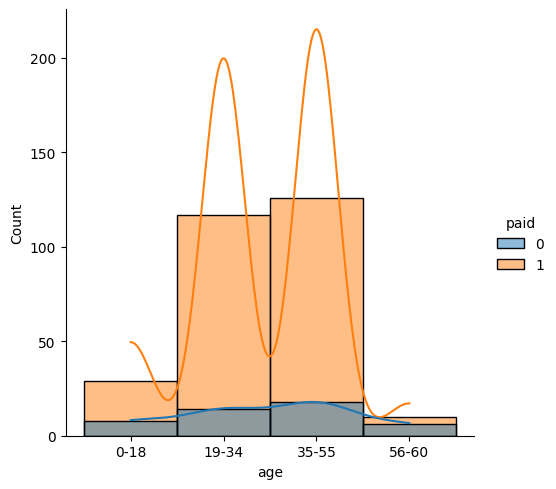

In [8]:
age_intervals = [0, 19, 35, 56, 61, 150]
age_intervals_labels = ['0-18', '19-34', '35-55', '56-60', 'retired']
def discretize_ages(df):
    df['age'] = pd.cut(x = df['age'], bins = age_intervals, labels=age_intervals_labels)

if not IS_LOADED:
    discretize_ages(joined_data)

sb.displot(x="age", data=joined_data, kde=True, hue="paid")

### Alter Age format to a number
`age` is a categorical value that represents a range. Instead of storing it as a string however, it can be represented by an integer based on a defined enum. The `age` values are now:
- 0 -> [0,18]
- 1 -> [19,34]
- 2 -> [35,55]
- 3 -> [56-60]
- 4 -> retired

In [9]:
ageToInt = {
    "0-18": 0,
    "19-34": 1,
    "35-55": 2,
    "56-60": 3,
    "retired": 4
}

def parse_init_age_range(df):
    def parse_init_inner(row):
        age = row['age']
        return int(ageToInt[age])

    df['age'] = df.apply(parse_init_inner, axis=1)
    
if not IS_LOADED:
    parse_init_age_range(joined_data)

## Analysis of the Client's info attributes

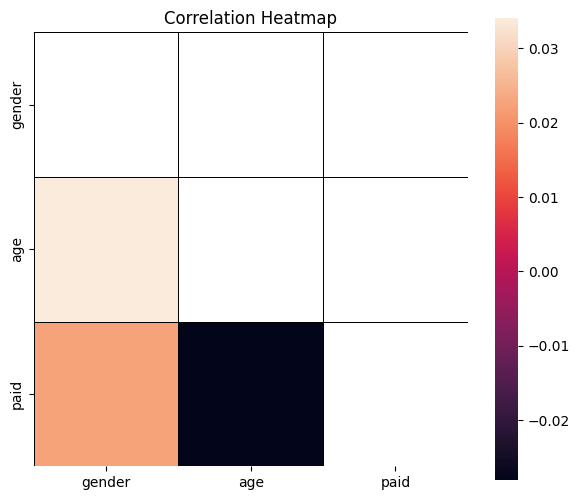

In [10]:
clientInfoCols = ["gender", "age"]

su.plot_corr(joined_data, clientInfoCols + ["paid"], methodName="spearman", annot=False, figSize=(7, 6))

If we perform a *chi-square test of Independence* to determine whether or not there is a significant association between the `clientInfoCols` and the `paid` property, we get the following results: 

In [11]:
su.chi_square_test(joined_data, clientInfoCols)

chi2:  13.875787772825582
p:  0.05343520827893905
dof:  7
expected:  [[ 2.94512195  8.55487805 10.79878049  0.42073171  2.24390244  9.81707317
   9.39634146  1.82317073]
 [18.05487805 52.44512195 66.20121951  2.57926829 13.75609756 60.18292683
  57.60365854 11.17682927]]
H0 accepted


Hence, the *Null Hypothesis* is accepted, confirming that there is no significant association between these variables

As shown above, the `gender` and `age` columns are not correlated. Furthermore, they do not appear to be very correlated with the `paid` property. Meaning that they will probably not be very helpful in the prediction of the `paid` property

Furthermore, the `birth_number` column will be dropped, since it's information is already contained in the `age` column

In [12]:
joined_data.drop(['birth_number'], axis='columns', inplace=True)

## Correlation between all the features of joined data

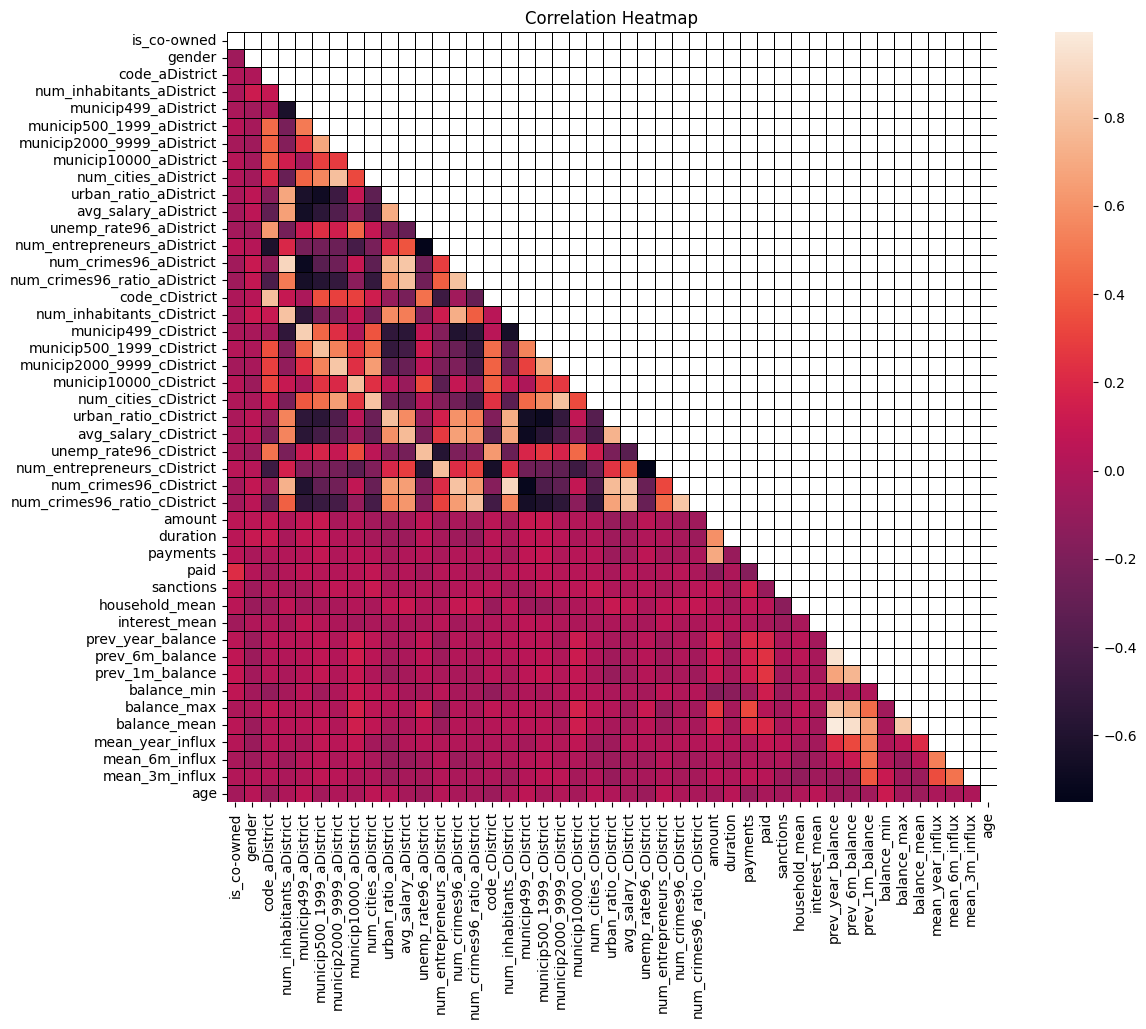

In [13]:
su.plot_corr(joined_data, joined_data.columns, methodName="spearman", annot=False, figSize=(15, 10))

In [14]:
joined_data

,frequency,a_date,is_co-owned,gender,code_aDistrict,name_aDistrict,region_aDistrict,num_inhabitants_aDistrict,municip499_aDistrict,municip500_1999_aDistrict,municip2000_9999_aDistrict,municip10000_aDistrict,num_cities_aDistrict,urban_ratio_aDistrict,avg_salary_aDistrict,unemp_rate95_aDistrict,unemp_rate96_aDistrict,num_entrepreneurs_aDistrict,num_crimes95_aDistrict,num_crimes96_aDistrict,num_crimes95_ratio_aDistrict,num_crimes96_ratio_aDistrict,code_cDistrict,name_cDistrict,region_cDistrict,num_inhabitants_cDistrict,municip499_cDistrict,municip500_1999_cDistrict,municip2000_9999_cDistrict,municip10000_cDistrict,num_cities_cDistrict,urban_ratio_cDistrict,avg_salary_cDistrict,unemp_rate95_cDistrict,unemp_rate96_cDistrict,num_entrepreneurs_cDistrict,num_crimes95_cDistrict,num_crimes96_cDistrict,num_crimes95_ratio_cDistrict,num_crimes96_ratio_cDistrict,loan_date,amount,duration,payments,paid,card_type,card_issued,sanctions,household_mean,interest_mean,prev_year_balance,prev_6m_balance,prev_1m_balance,balance_min,balance_max,balance_mean,mean_year_influx,mean_6m_influx,mean_3m_influx,age
0,weekly issuance,1993-03-22,0,0,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483356537147195,29.574315,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,3.38,3.67,100.0,2985.0,2804,31.483356537147195,29.574315,1993-07-05,96396,12,8033,0,none,none,0,7266.0,128.930000,12250.000000,12250.000000,20100.000000,1100.0,20100.0,12250.000000,1675.000000,3350.000000,6333.333333,2
1,monthly issuance,1993-02-13,0,1,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.32184652512222,23.227959,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,1.79,2.31,117.0,2854.0,2618,25.32184652512222,23.227959,1993-07-11,165960,36,4610,1,none,none,0,15925.0,118.091667,52083.859459,52083.859459,33113.788889,700.0,120512.8,52083.859459,4350.741667,8701.483333,-12278.966667,1
2,monthly issuance,1993-02-08,0,1,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695072962254702,27.234108,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132.0,2080.0,2122,26.695072962254702,27.234108,1993-07-28,127080,60,2118,1,none,none,0,6393.0,193.711111,30060.954167,30060.954167,36233.066667,800.0,49590.4,30060.954167,1689.416667,3378.833333,-2448.833333,3
3,monthly issuance,1993-01-30,0,0,14,Ceske Budejovice,south Bohemia,177686,69,27,10,1,9,74.8,10045,1.42,1.71,135.0,6604.0,6295,37.16668730231982,35.427665,12,Pribram,central Bohemia,107870,84,29,6,1,6,58.0,8754,3.83,4.31,137.0,3804.0,3868,35.26467043663669,35.857977,1993-08-03,105804,36,2939,1,none,none,0,0.0,252.633333,41297.480000,42976.541667,42535.133333,1000.0,65898.5,41297.480000,2857.716667,5548.766667,-990.000000,2
4,weekly issuance,1993-02-14,0,1,63,Vyskov,south Moravia,86513,38,36,5,1,5,50.5,8288,3.79,4.52,110.0,1562.0,1460,18.05508998647602,16.876076,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167.0,85677.0,99107,71.10401816502386,82.249681,1993-09-06,274740,60,4579,1,none,none,0,6256.0,122.200000,57188.211111,59364.680769,49872.757143,600.0,122893.1,57188.211111,3426.091667,6752.183333,-6138.033333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,monthly issuance,1995-01-21,1,0,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.773370127630216,40.721380,72,Olomouc,north Moravia,226122,32,50,7,4,4,62.6,8994,3.8,4.79,110.0,9672.0,9208,42.773370127630216,40.721380,1996-12-12,155616,48,3242,1,none,none,0,9810.0,213.500000,45928.792079,43900.685714,54345.971429,200.0,75294.1,44197.509884,-39.675000,-2094.533333,2870.900000,1
324,monthly issuance,1995-11-29,0,1,29,Rokycany,west Bohemia,45714,52,10,5,1,6,55.6,8843,2.82,3.60,113.0,818.0,888,17.89386183663648,19.425121,29,Rokycan

In [15]:
IS_LOADED = True